In [1]:
import os
import glob
import json
import pandas as pd
import log_codes as log
import log_print_functions as log_print
from datetime import datetime, date, time

directory_path = './logs/dut0_iv_tee/logs_client'
file_pattern = 'Client_dut*'

# Use glob to find all files matching the pattern
file_paths = glob.glob(os.path.join(directory_path, file_pattern))

def parse_files(file_paths):
    frames = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for json_line in file:
                # Parse frame
                try:
                    frame = json.loads(json_line)
                except Exception as error:
                    print(f"Failed decoding JSON for file {file_path}: {error}")
                frames.append(frame)
    return frames

frames_original = sorted(parse_files(file_paths), key=lambda x: x["timestamp"])
raw_df = pd.DataFrame(frames_original)

### Converting Unix timestamp to UTC

And droping any duplicates.... Why do we do this though?????

In [2]:
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='s').dt.tz_localize('UTC')
# raw_df = raw_df.drop_duplicates()
raw_df

,message,type,id,timestamp,data,event
0,,Serial dut0_monitor,20,2023-12-08 17:34:20.871259904+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
1,,Serial dut0_monitor,20,2023-12-08 17:34:22.807990272+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
2,,Serial dut0_monitor,20,2023-12-08 17:34:24.750655488+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
3,,Serial dut0_monitor,20,2023-12-08 17:34:26.687566592+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
4,,Serial dut0_monitor,20,2023-12-08 17:34:28.631791872+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
...,...,...,...,...,...,...
52564,,Serial dut0_monitor,20,2023-12-10 06:31:41.211050240+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
52565,,Serial dut0_monitor,20,2023-12-10 06:31:43.154351616+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
52566,,Serial dut0_monitor,20,2023-12-10 06:31:45.090921728+00:00,aa013c000000004806c005b38bab004538f80066424602...,NaN
52567,,Serial dut0_monitor,20,2023-12-10 06:31:46.125013760+00:00, ,NaN


## Custom frame decoding

In ```log_codes.py``` you can create the dictionary that holds the frame formatting for a given frame ID. This will be custom to your specific frame. Find the documentation for each field in payload_parser. 

Also define the keys for each element.

Now, parse the fields based on frame type and then parsing the data tuple into readable fields


In [3]:

# Parse raw frame into executions
execution_df = log.parse_data(raw_df)
try:
    execution_df['timestamp'] = pd.to_datetime(execution_df['timestamp']).dt.tz_localize('UTC')
except Exception as error:
    print(f"Error converting timestamp to datetime: {error}")

execution_df[814:817]


,event,timestamp,total_errors,mcycle,minstret,ir_c,wait_ii,wait_if,wait_mc,load,store,wait_ls,branch,tbranch,imem_ecc,dmem_ecc,regfile,iv
814,0,2023-12-08 18:00:39.877042432+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,7702,0,0,7702,0
815,0,2023-12-08 18:00:41.820200704+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,7702,0,0,7702,0
816,0,2023-12-08 18:00:43.756218624+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,7702,0,0,7702,0


# Separate into runs

Now that we have the events correctly embedded in the data, we separate the runs according to events.

Each timeout event generates a discontinuity in the data. Each discontinuity is a new run. We remove runs that are composed only of events. 

In [4]:

list_of_runs = []
start_index = 0
for index, row in execution_df.iterrows():
    if row['event'] == log.ERROR_TIMEOUT:
        sliced_df = execution_df[start_index:index]
        list_of_runs.append(sliced_df)
        start_index = index
sliced_df = execution_df[start_index:]
list_of_runs.append(sliced_df)

# Remove invalid runs
list_of_runs = [df for df in list_of_runs if not all(df['event'] != 0)]

# Remove timeout from run slice
for i in range(len(list_of_runs)):
    if len(list_of_runs[i]) > 0 and list_of_runs[i].iloc[0]['event'] == 5:
        list_of_runs[i] = list_of_runs[i].iloc[1:]

#Number of runs
print(f"Number of valid runs = {len(list_of_runs)}")


Number of valid runs = 2578


In [5]:
list_of_runs[8]

,event,timestamp,total_errors,mcycle,minstret,ir_c,wait_ii,wait_if,wait_mc,load,store,wait_ls,branch,tbranch,imem_ecc,dmem_ecc,regfile,iv
15199,1,2023-12-09 01:49:45.397580544+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15200,0,2023-12-09 01:49:47.339739392+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,0,0,0,0,0
15201,0,2023-12-09 01:49:49.276196864+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,0,0,0,0,0
15202,0,2023-12-09 01:49:51.219905280+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,0,0,0,0,0
15203,0,2023-12-09 01:49:53.156214272+00:00,0,96470600,11242419,16267333,38158950,22063286,4381079,1426024,16196283,817756,509563,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,0,2023-12-09 06:27:05.574759424+00:00,2,70289730,8378153,6338522,21757711,21884072,3500982,1090552,10357746,522742,354270,72803,0,0,58304,0
24536,0,2023-12-09 06:27:06.992647424+00:00,2,70289730,8378153,6338522,21757711,21884072,3500982,1090552,10357746,522742,354270,72803,0,0,58304,0
24537,0,2023-12-09 06:27:08.408001280+00:00,2,70289730,8378153,6338522,21757711,21884072,3500982,1090552,10357746,522742,354270,72803,0,0,58304,0
24538,0,2023-12-09 06:27:09.825478912+00:00,2,70289730,8378153,6338522,21757711,21884072,3500982,1090552,10357746,522742,354270,72803,0,0,58304,0


-------------

# Data Analysis

Using ```list_of_runs``` as input

### Timestamps and totals for each run

Get start, end, and total number of errors for each run

In [6]:
index = 0

for df in list_of_runs:
    start = df.iloc[0]['timestamp']
    end = df.iloc[-1]['timestamp']
    total_time = end - start
    total_imem_de = df['imem_ecc'].sum()
    # total_dsp_t = df['dsp_t'].sum()
    total_errors = df['total_errors'].sum()
    # total_errors = df['imem_se'].sum()
    # print(start.hour)

    
    # if start.hour > 10 or (start.hour >= 10 and start.minute >= 30):
    start_str = start.strftime("%d %H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
    end_str = end.strftime("%H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
    duration = round((end - start).total_seconds(), 1)  # Limit duration to 2 decimal places
    if duration > 60:
        print(f"{index} \t| Duration = {duration}  \t| Start: \t{start_str} -- {end_str}")
        # print(f"Start: \t{start_str}")
        # print(f"End: \t{end_str}")
    # print(f"Total Time: {total_time}")
    # print(f"Total Errors: {total_errors}")
    # print(f"Total dsp_t: {total_dsp_t}")
    # print(f"Total imem_de: {total_imem_de}")
    # print()
    index += 1


0 	| Duration = 5973.0  	| Start: 	08 17:34:20.871 -- 19:13:53.910
3 	| Duration = 4410.4  	| Start: 	08 19:17:36.443 -- 20:31:06.880
4 	| Duration = 725.6  	| Start: 	08 20:32:04.018 -- 20:44:09.650
6 	| Duration = 4260.7  	| Start: 	08 21:01:05.425 -- 22:12:06.124
7 	| Duration = 12861.1  	| Start: 	08 22:14:27.029 -- 01:48:48.142
8 	| Duration = 16645.8  	| Start: 	09 01:49:45.397 -- 06:27:11.242
9 	| Duration = 613.7  	| Start: 	09 06:27:19.742 -- 06:37:33.481
10 	| Duration = 952.7  	| Start: 	09 06:38:30.386 -- 06:54:23.052
11 	| Duration = 3252.7  	| Start: 	09 06:54:32.755 -- 07:48:45.484
12 	| Duration = 1433.7  	| Start: 	09 07:49:42.786 -- 08:13:36.484
13 	| Duration = 322.0  	| Start: 	09 08:13:46.190 -- 08:19:08.231
14 	| Duration = 4831.1  	| Start: 	09 08:20:05.106 -- 09:40:36.249
442 	| Duration = 111.5  	| Start: 	09 11:06:50.731 -- 11:08:42.197
465 	| Duration = 219.2  	| Start: 	09 11:15:14.893 -- 11:18:54.122
470 	| Duration = 1620.1  	| Start: 	09 11:20:02.016 -- 1

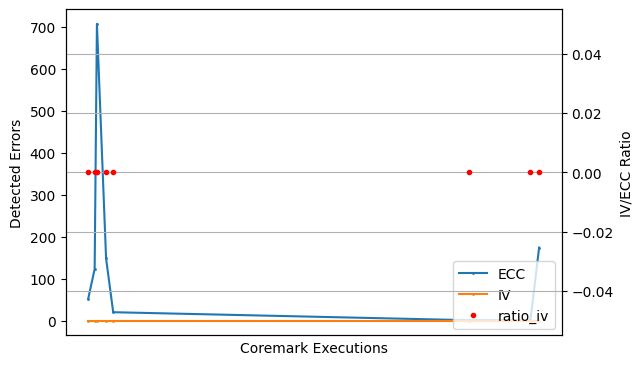

0.0 0.0


In [7]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[8][list_of_runs[8]['timestamp'].dt.day == 9]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(1,49)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(6,27)]
filtered_df = filtered_df[filtered_df['imem_ecc'] > 0]

log_print.plot_imem_iv_tee(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_ecc"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_ecc"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



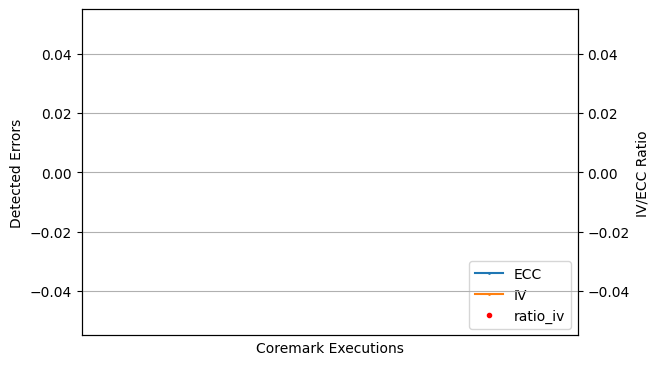

KeyError: 'imem_se'

In [8]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[1]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(22,56)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(2,17)]
filtered_df = filtered_df[filtered_df['imem_ecc'] > 0]

log_print.plot_imem_iv_tee(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



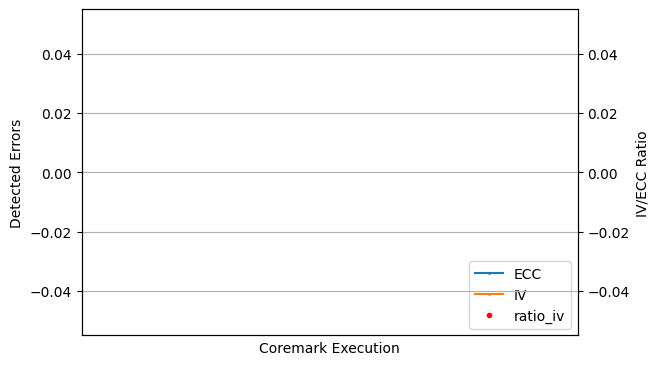

nan nan


In [ ]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[2][list_of_runs[2]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(2,18)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(5,39)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv_tee(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



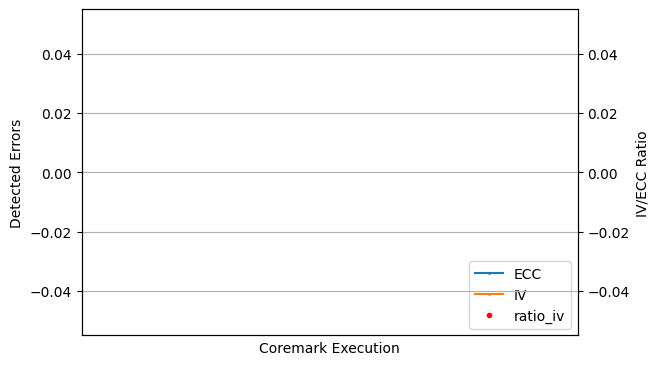

nan nan


In [ ]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[3][list_of_runs[3]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(5,40)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(8,58)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv_tee(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



In [ ]:

# # Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# filtered_df = list_of_runs[4][list_of_runs[4]['timestamp'].dt.day == 8]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(15,12)]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(17,6)]
# filtered_df = filtered_df[filtered_df['imem_se'] > 0]

# log_print.plot_imem_iv_tee_tee(filtered_df)

# filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
# filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

# mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
# std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

# print(mean_ratio_iv, std_ratio_iv)

